## Setup

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from DataMaker import *

In [1]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 100
GB_LIMIT = 10
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-7
# Good max value: 0.00001

In [3]:
DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v7"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
dir_model = os.path.join('/models', model_id, 'model')
dir_checkpoints = os.path.join('/models', model_id, 'checkpoints')
dir_logs = os.path.join('/logs', model_id)
dir_predictions = os.path.join('/predictions', model_id)
weights_file = dir_model + '/weights.h5'

print(weights_file)
print(dir_model)
print(dir_checkpoints)
print(dir_logs)
print(dir_predictions)

os.makedirs(dir_model, exist_ok=True)
os.makedirs(dir_checkpoints, exist_ok=True)
os.makedirs(dir_logs, exist_ok=True)
os.makedirs(dir_predictions, exist_ok=True)

/models/HSC_v6_small_VAE_v7/model/weights.h5
/models/HSC_v6_small_VAE_v7/model
/models/HSC_v6_small_VAE_v7/checkpoints
/logs/HSC_v6_small_VAE_v7
/predictions/HSC_v6_small_VAE_v7


## Allocate GPU

Make sure to check others' current usage on Aurora in terminal using `watch nvidia-smi`. Set your `GB_LIMIT` accordingly, in gigabytes. Aurora has 50GB of memory.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GB_LIMIT* 2000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-10-26 20:14:06.739226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:14:06.746494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:14:06.747175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:14:06.748430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Data

Create the shuffled and batched data generators.

from albumentations import Compose
from albumentations.augmentations.transforms import ToFloat

my_augmenter = Compose([ToFloat(max_value=4.16)])
batch_args_gen = {'X_key': 'image', 'y_key': 'image', 'labels_encoding': False, 'scaler': False,
                  'batch_size': BATCH_SIZE, 'mode': 'train', 'shuffle': True}
args_gen = {'X_key': 'image', 'y_key': 'image', 'labels_encoding': False, 'scaler': False,
            'batch_size': 1, 'mode': 'test', 'shuffle': False}
start_path = "/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_"
TRAIN_PATH = start_path + "training_small.hdf5"
VAL_PATH = start_path + "validation_small.hdf5"
TEST_PATH = start_path + "testing_small.hdf5"

train_gen = HDF5ImageGenerator(src=TRAIN_PATH, **batch_args_gen)
val_gen = HDF5ImageGenerator(src=VAL_PATH, **batch_args_gen)
test_gen = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

In [5]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

for i in range(0,10000):
    if y_train[i]>=0.1:
        np.delete(x_train, i)
        np.delete(y_train, i)
for i in range(0,2000):
    if y_test[i]>=0.1:
        np.delete(x_test, i)
        np.delete(y_test, i)
for i in range(0,2000):
    if y_validation[i]>=0.1:
        np.delete(x_validation, i)
        np.delete(y_validation, i)

## Callbacks

What we'd like to save during training.

- Metrics logs per epoch to visualise in TensorBoard.
- Model weights per epoch.
- Predictions and corresponding metrics per prediction per epoch.

An alternative to ReduceLROnPlateau is LearningRateScheduler to decrease step size after a fixed number of epochs, but I think we'd prefer to do it by metric.

In [6]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

logs_callback = TensorBoard(log_dir=dir_logs)
weights_callback = ModelCheckpoint(filepath=os.path.join(dir_checkpoints, 'weights_epoch{epoch}.hdf5'),
                                   save_freq=int(EPOCHS/CHECKPOINTS_TO_SAVE),
                                   save_weights_only=True
                                  )
LR_callback = ReduceLROnPlateau()

## VAE Model

### Define model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims=1)

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape=IMAGE_SHAPE)
        x = Conv2D(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(images)
        x = Conv2D(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(8, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Flatten()(x)
        x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation=None)(x)
        z = tfpl.MultivariateNormalTriL(LATENT_DIM,
                  activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=KL_WEIGHT))(x)
        self.encoder = Model(images, z, name='encoder')

        latents = Input(shape=LATENT_DIM)
        x = Dense(4*LATENT_DIM*32*32, activation=None)(latents)
        x = Reshape((4*LATENT_DIM,32,32))(x)
        x = Conv2DTranspose(8, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2D(IMAGE_SHAPE[0], 3, strides=1, activation=None, 
                   padding='same', data_format='channels_first')(x)
        outputs = Cropping2D(cropping=((0,1),(0,1)), data_format='channels_first')(x)
        self.decoder = Model(latents, outputs, name='decoder')

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [8]:
model = VAE()

In [9]:
model.compile(optimizer='adam', loss='mse')

In [10]:
model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 127, 127)]     0         
                                                                 
 conv2d (Conv2D)             (None, 8, 127, 127)       368       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 64, 64)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 64, 64)         584       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 32, 32)         584       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 32, 32)         584       
                                                                 
 flatten (Flatten)           (None, 8192)              0   

### Train model

In [11]:
history = model.fit(
    x = x_train,
    y = x_train,
    epochs = 200,
    # callbacks=[logs_callback, weights_callback],
    validation_data = (x_validation, x_validation),
    verbose=2)

2022-10-26 20:14:28.331208: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3225800000 exceeds 10% of free system memory.
2022-10-26 20:14:29.413583: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3225800000 exceeds 10% of free system memory.
2022-10-26 20:14:30.480033: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3225800000 exceeds 10% of free system memory.
2022-10-26 20:14:31.328988: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3225800000 exceeds 10% of free system memory.


Epoch 1/200


2022-10-26 20:16:35.137071: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-10-26 20:19:19.536423: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-26 20:19:19.994236: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 - 415s - loss: 0.1673 - val_loss: 0.1437 - 415s/epoch - 1s/step
Epoch 2/200
313/313 - 7s - loss: 0.1420 - val_loss: 0.1391 - 7s/epoch - 23ms/step
Epoch 3/200
313/313 - 7s - loss: 0.1393 - val_loss: 0.1463 - 7s/epoch - 23ms/step
Epoch 4/200
313/313 - 7s - loss: 0.1381 - val_loss: 0.1403 - 7s/epoch - 23ms/step
Epoch 5/200
313/313 - 7s - loss: 0.1333 - val_loss: 0.1313 - 7s/epoch - 23ms/step
Epoch 6/200
313/313 - 7s - loss: 0.1315 - val_loss: 0.1325 - 7s/epoch - 23ms/step
Epoch 7/200
313/313 - 7s - loss: 0.1306 - val_loss: 0.1311 - 7s/epoch - 23ms/step
Epoch 8/200
313/313 - 7s - loss: 0.1356 - val_loss: 0.1525 - 7s/epoch - 23ms/step
Epoch 9/200
313/313 - 7s - loss: 0.1316 - val_loss: 0.1366 - 7s/epoch - 23ms/step
Epoch 10/200
313/313 - 7s - loss: 0.1284 - val_loss: 0.1315 - 7s/epoch - 23ms/step
Epoch 11/200
313/313 - 7s - loss: 0.1295 - val_loss: 0.1305 - 7s/epoch - 23ms/step
Epoch 12/200
313/313 - 7s - loss: 0.1241 - val_loss: 0.1266 - 7s/epoch - 23ms/step
Epoch 13/200
313/313 - 

Epoch 100/200
313/313 - 7s - loss: 0.0545 - val_loss: 0.0945 - 7s/epoch - 23ms/step
Epoch 101/200
313/313 - 7s - loss: 0.0550 - val_loss: 0.0934 - 7s/epoch - 23ms/step
Epoch 102/200
313/313 - 7s - loss: 0.0532 - val_loss: 0.0943 - 7s/epoch - 23ms/step
Epoch 103/200
313/313 - 7s - loss: 0.0584 - val_loss: 0.0945 - 7s/epoch - 23ms/step
Epoch 104/200
313/313 - 7s - loss: 0.0547 - val_loss: 0.0925 - 7s/epoch - 23ms/step
Epoch 105/200
313/313 - 7s - loss: 0.0534 - val_loss: 0.0877 - 7s/epoch - 23ms/step
Epoch 106/200
313/313 - 7s - loss: 0.0546 - val_loss: 0.1011 - 7s/epoch - 23ms/step
Epoch 107/200
313/313 - 7s - loss: 0.0519 - val_loss: 0.0940 - 7s/epoch - 23ms/step
Epoch 108/200
313/313 - 7s - loss: 0.0513 - val_loss: 0.0957 - 7s/epoch - 23ms/step
Epoch 109/200
313/313 - 7s - loss: 0.0525 - val_loss: 0.0907 - 7s/epoch - 23ms/step
Epoch 110/200
313/313 - 7s - loss: 0.0507 - val_loss: 0.0940 - 7s/epoch - 23ms/step
Epoch 111/200
313/313 - 7s - loss: 0.0535 - val_loss: 0.0926 - 7s/epoch - 23

Epoch 198/200
313/313 - 7s - loss: 0.0310 - val_loss: 0.0915 - 7s/epoch - 23ms/step
Epoch 199/200
313/313 - 7s - loss: 0.0330 - val_loss: 0.0873 - 7s/epoch - 23ms/step
Epoch 200/200
313/313 - 7s - loss: 0.0343 - val_loss: 0.0827 - 7s/epoch - 23ms/step


### Save final model

In [14]:
# model.save_weights(weights_file)

## Save final predictions

In [15]:
from sys import stdout
from time import sleep

In [16]:
def save_preds(dataset='train', num_to_save=None):
    if dataset == 'train':
        datagen = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
    elif dataset == 'val':
        datagen = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
    else:
        dataset = 'test'
        datagen = test_gen
    preds_path = os.path.join(dir_predictions, dataset + "_preds.hdf5")
    print("Saving predictions for", dataset, "dataset in", preds_path)
    
    if num_to_save is None:
        size = len(datagen._indices)
    else:
        size = num_to_save

    with h5py.File(preds_path, 'w') as f:
        f.create_dataset('true', (size, ) + IMAGE_SHAPE)
        f.create_dataset('pred', (size, ) + IMAGE_SHAPE)
        f.create_dataset('loss', size)
        it = iter(datagen)
        for i in range(size):
            x = next(it)
            f['true'][i] = x
            f['pred'][i] = model.predict(x, verbose=0)
            f['loss'][i] = model.evaluate(x, x, verbose=0)
            stdout.write("\rSaved %d samples of " % i + str(size))
            stdout.flush()
            i += 1

In [17]:
# save_preds('train')

In [18]:
# save_preds('val')

In [19]:
# save_preds('test')

def display_preds(dataset='train', num_to_show=10):
    preds_path = os.path.join(dir_predictions, dataset + "_preds.hdf5")    
    with h5py.File(preds_path, 'r') as f:
        fig, axes = plt.subplots(nrows=num_to_show, ncols=2, figsize=(10,5*num_to_show))
        for i in range(num_to_show):
            axes[i][0].imshow(np.array([x_test[i]])[0][1])
            axes[i][0].set_title('True')
            axes[i][1].imshow(model(np.array([x_test[i]]))[0][1])
            axes[i][1].set_title("Pred, loss %.2f" % f['loss'][i])

In [139]:
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    for i in range(0,5):
        axes[0][i].imshow(np.array([x_test[index]])[0][i])
        max_pixel_true = round(np.amax(np.array([x_test[index]])[0][i]), 2)
        axes[0][i].set_title(f'True band {i} max = ' + str(max_pixel_true))
        pred = model(np.array([x_test[index]]))[0][i]
        axes[1][i].imshow(pred)
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'Pred band {i} max = ' + str(max_pixel_pred))

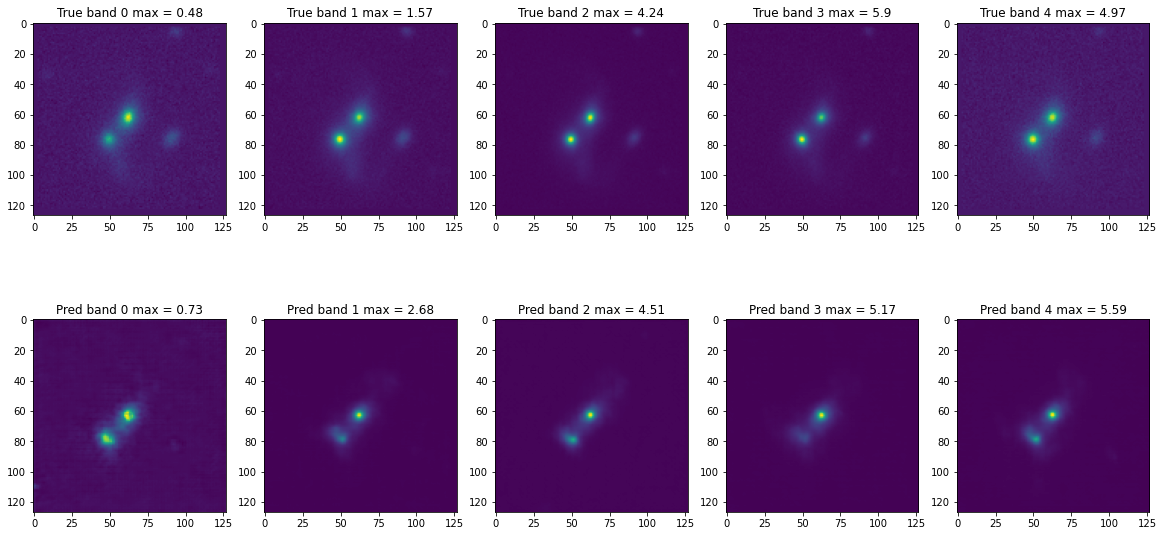

In [140]:
display_5_bands(4)

display_preds('val', num_to_show=10)

### Example generations

In [22]:
from matplotlib import gridspec
import math

def generate_example_galaxies(num_to_generate=10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    cols = 3
    rows = int(math.ceil(num_to_generate / cols))
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(15, 5*rows))
    for i in range(num_to_generate):
        ax = fig.add_subplot(gs[i])
        ax.imshow(xhat[i][0])
        ax.set_title(f'Generated image {i}')

In [67]:
def generate_example_galaxies(num_to_generate = 10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    fig, axes = plt.subplots(nrows = num_to_generate, ncols = 5, figsize = (4 * 5, 4 * num_to_generate))
    for i in range(num_to_generate):
        for j in range(0,5):
            axes[i][j].imshow(xhat[i][j])
            axes[i][j].set_title(f'Generated image {i} band {j}')

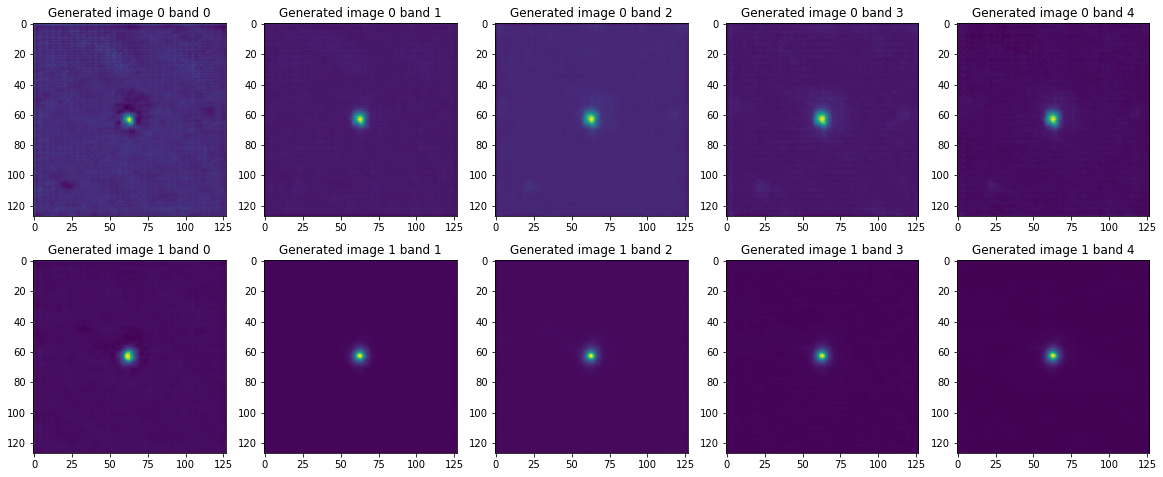

In [120]:
generate_example_galaxies(2)